In [1]:
import math
import random

import matplotlib.pyplot as plt
import pydiffvg
import torch
import skimage
import skimage.io
import ttools.modules

In [2]:
torch.cuda.is_available()

True

In [3]:
pydiffvg.set_use_gpu(torch.cuda.is_available())

In [4]:
pydiffvg.get_device()

device(type='cuda')

In [5]:
fp = '../../data/sandbox/figure_1.jpeg'

In [6]:
target = torch.tensor(skimage.io.imread(fp)).to(torch.float32) / 255.0
target.shape

torch.Size([508, 360, 3])

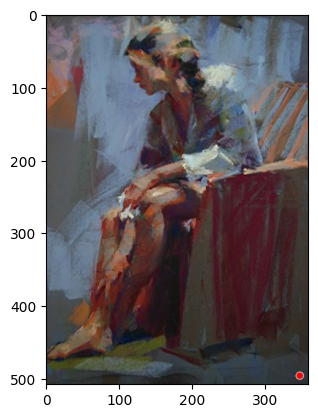

In [7]:
plt.imshow(target)

In [8]:
target = target.to(pydiffvg.get_device())
target = target.unsqueeze(0)
target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
target.shape

torch.Size([1, 3, 508, 360])

In [9]:
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_paths = [500, 500, 500, 500, 500]
max_width = 10.
use_blob = False
num_iter = 101

In [10]:
# layer_to_shapes, layer_to_shape_groups = [], []
# for n in num_paths:
#     shapes = []
#     shape_groups = []
#     for i in range(n):
#         num_segments = random.randint(3, 5)
#         num_control_points = torch.zeros(num_segments, dtype=torch.int32) + 2
#         points = []
#         p0 = (random.random(), random.random())
#         points.append(p0)
#         for j in range(num_segments):
#             radius = 0.05
#             p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
#             p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
#             p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
#             points.append(p1)
#             points.append(p2)
#             if j < num_segments - 1:
#                 points.append(p3)
#                 p0 = p3
#         points = torch.tensor(points)
#         points[:, 0] *= canvas_width
#         points[:, 1] *= canvas_height
#         path = pydiffvg.Path(num_control_points = num_control_points,
#                              points = points,
#                              stroke_width = torch.tensor(1.0),
#                              is_closed = True)
#         shapes.append(path)
#         path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
#                                          fill_color = torch.tensor([random.random(),
#                                                                     random.random(),
#                                                                     random.random(),
#                                                                     random.random()]))
#         shape_groups.append(path_group)
#     layer_to_shapes.append(shapes)
#     layer_to_shape_groups.append(shape_groups)

In [10]:
layer_to_shapes, layer_to_shape_groups = [], []
for n in num_paths:
    shapes = []
    shape_groups = []
    for i in range(n):
        num_segments = random.randint(1, 3)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.05
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            points.append(p3)
            p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height
        #points = torch.rand(3 * num_segments + 1, 2) * min(canvas_width, canvas_height)
        path = pydiffvg.Path(num_control_points = num_control_points,
                             points = points,
                             stroke_width = torch.tensor(1.0),
                             is_closed = False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                         fill_color = None,
                                         stroke_color = torch.tensor([random.random(),
                                                                      random.random(),
                                                                      random.random(),
                                                                      random.random()]))
        shape_groups.append(path_group)
    layer_to_shapes.append(shapes)
    layer_to_shape_groups.append(shape_groups)

In [11]:
def render_scene(canvas_width, canvas_height, shapes, shape_groups):
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)

    render = pydiffvg.RenderFunction.apply
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    return img

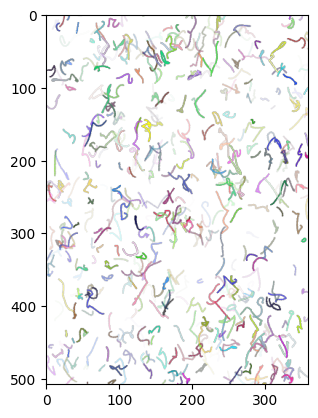

In [12]:
img = render_scene(canvas_width, canvas_height, layer_to_shapes[0], layer_to_shape_groups[0])
plt.imshow(img.cpu().detach())

In [13]:
layer_to_shapes[0][0].points

tensor([[271.6786, 318.6407],
        [278.9321, 328.2251],
        [270.5742, 340.3834],
        [272.0867, 338.2338]])

In [14]:
layer_to_shapes[0][0].stroke_width

tensor(1.)

In [15]:
layer_to_shape_groups[0][0].stroke_color

tensor([0.5414, 0.5855, 0.3550, 0.5525])

In [16]:
points_vars = []
stroke_width_vars = []
color_vars = []
for shapes, shape_groups in zip(layer_to_shapes, layer_to_shape_groups):
    for path in shapes:
        path.points.requires_grad = True
        points_vars.append(path.points)
    if not use_blob:
        for path in shapes:
            path.stroke_width.requires_grad = True
            stroke_width_vars.append(path.stroke_width)
    if use_blob:
        for group in shape_groups:
            group.fill_color.requires_grad = True
            color_vars.append(group.fill_color)
    else:
        for group in shape_groups:
            group.stroke_color.requires_grad = True
            color_vars.append(group.stroke_color)

In [17]:
imgs = torch.zeros(len(layer_to_shapes), canvas_height, canvas_width, 3, dtype=torch.float32)
for i, (shapes, shape_groups) in enumerate(zip(layer_to_shapes, layer_to_shape_groups)):
    img = render_scene(canvas_width, canvas_height, shapes, shape_groups)
    # Compose img with white background
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    imgs[i] = img

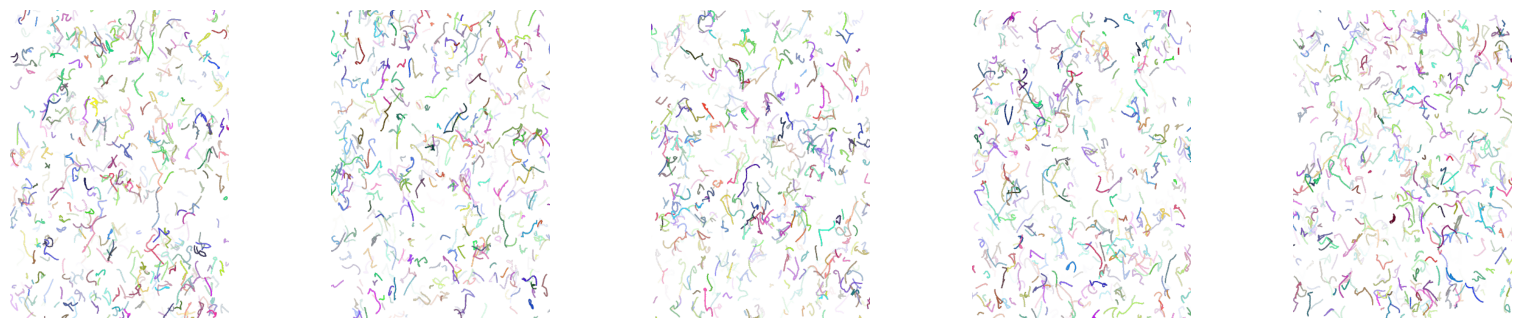

In [18]:
fig, axs = plt.subplots(ncols=imgs.shape[0], figsize=(20, 4))
for img, ax in zip(imgs, axs):
    ax.imshow(img.cpu().detach())
    ax.axis('off')

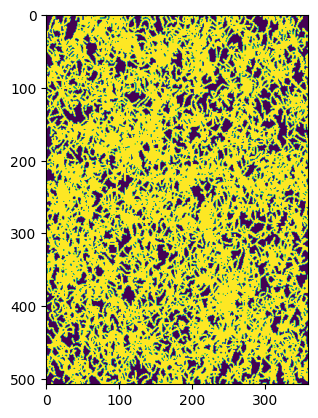

In [19]:
mask = imgs.sum(dim=(0, -1))!=imgs.shape[0] * 3
plt.imshow(mask.cpu().detach())

In [20]:
def merge_imgs(x1, x2):
    x1, x2 = 1 - x1, 1 - x2 # easier operations with flipped intensity
    m1, m2 = x1.sum(dim=-1)!=0, x2.sum(dim=-1)!=0
    both = m1 & m2
    
    img_both = x1 + x2
    merged = (x1 + x2) / 2
    img_both[both] = merged[both]
    
    return 1 - img_both

def merge_img_stack(imgs):
    img = None
    for i in range(imgs.shape[0]):
        if img is None:
            img = imgs[i]
        else:
            img = merge_imgs(img, imgs[i])
    return img

In [21]:
# Optimizers
points_optim = torch.optim.Adam(points_vars, lr=1.0)
if len(stroke_width_vars) > 0:
    width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

iteration: 0


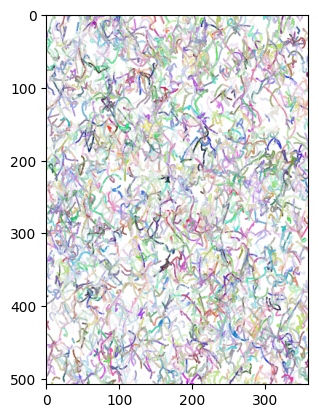

render loss: 0.32765161991119385
iteration: 1
render loss: 0.2986685633659363
iteration: 2
render loss: 0.2739116847515106
iteration: 3
render loss: 0.2514432370662689
iteration: 4
render loss: 0.23100388050079346
iteration: 5
render loss: 0.2124975472688675
iteration: 6
render loss: 0.19603443145751953
iteration: 7
render loss: 0.1808563470840454
iteration: 8
render loss: 0.16703926026821136
iteration: 9
render loss: 0.15414880216121674
iteration: 10
render loss: 0.14223501086235046
iteration: 11
render loss: 0.13117285072803497
iteration: 12
render loss: 0.12079780548810959
iteration: 13
render loss: 0.11089296638965607
iteration: 14
render loss: 0.10138683021068573
iteration: 15
render loss: 0.09238891303539276
iteration: 16
render loss: 0.08388251811265945
iteration: 17
render loss: 0.07594724744558334
iteration: 18
render loss: 0.06847859919071198
iteration: 19
render loss: 0.061678141355514526
iteration: 20
render loss: 0.05532391369342804
iteration: 21
render loss: 0.04954333603

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


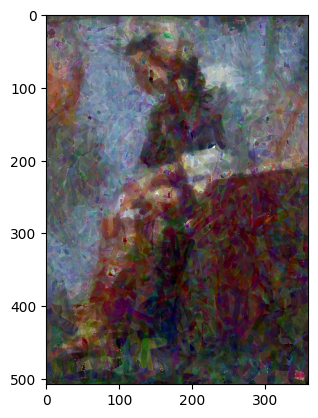

render loss: 0.00641876645386219
iteration: 51
render loss: 0.006205605808645487
iteration: 52
render loss: 0.005993808154016733
iteration: 53
render loss: 0.005805079825222492
iteration: 54
render loss: 0.0056084259413182735
iteration: 55
render loss: 0.005438312888145447
iteration: 56
render loss: 0.0052855354733765125
iteration: 57
render loss: 0.005150590091943741
iteration: 58
render loss: 0.005028745159506798
iteration: 59
render loss: 0.004889486823230982
iteration: 60
render loss: 0.004770367406308651
iteration: 61
render loss: 0.004670220427215099
iteration: 62
render loss: 0.004571570549160242
iteration: 63
render loss: 0.0044733500108122826
iteration: 64
render loss: 0.004372854251414537
iteration: 65
render loss: 0.004276403691619635
iteration: 66
render loss: 0.004178374540060759
iteration: 67
render loss: 0.004069030284881592
iteration: 68
render loss: 0.003970792051404715
iteration: 69
render loss: 0.0038719680160284042
iteration: 70
render loss: 0.0037877371069043875
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


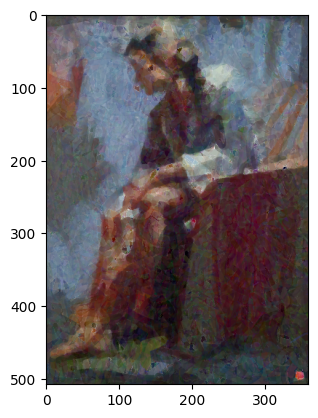

render loss: 0.0025210329331457615


In [22]:
# Adam iterations.
for t in range(num_iter):
    print('iteration:', t)
    
    # zero grads
    points_optim.zero_grad()
    if len(stroke_width_vars) > 0:
        width_optim.zero_grad()
    color_optim.zero_grad()
    
    # Forward pass: render the image.
    imgs = torch.zeros(len(layer_to_shapes), canvas_height, canvas_width, 3, dtype=torch.float32, device=pydiffvg.get_device())
    for i, (shapes, shape_groups) in enumerate(zip(layer_to_shapes, layer_to_shape_groups)):
        img = render_scene(canvas_width, canvas_height, shapes, shape_groups)
        # Compose img with white background
        img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(
            img.shape[0], img.shape[1], 3, device=pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        imgs[i] = img
    img = merge_img_stack(imgs)
    
    if t % 50 == 0:
        plt.imshow(img.cpu().detach())
        plt.show()
    
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
#     if args.use_lpips_loss:
#         loss = perception_loss(img, target) + (img.mean() - target.mean()).pow(2)
#     else:
    loss = (img - target).pow(2).mean()
    print('render loss:', loss.item())

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    if len(stroke_width_vars) > 0:
        width_optim.step()
    color_optim.step()

    if len(stroke_width_vars) > 0:
        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
            path.stroke_width.data.clamp_(.1, max_width)
    if use_blob:
        for group in shape_groups:
            group.fill_color.data.clamp_(0.0, 1.0)
    else:
        for group in shape_groups:
            group.stroke_color.data.clamp_(0.0, 1.0)

#     if t % 10 == 0 or t == args.num_iter - 1:
#         pydiffvg.save_svg('results/painterly_rendering/iter_{}.svg'.format(t),
#                           canvas_width, canvas_height, shapes, shape_groups)

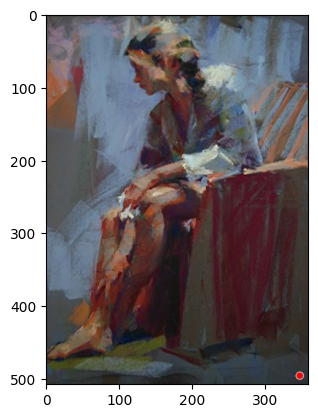

In [25]:
plt.imshow(target[0].cpu().detach().permute(1, 2, 0))

In [26]:
target[0].cpu().detach().shape

torch.Size([3, 508, 360])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


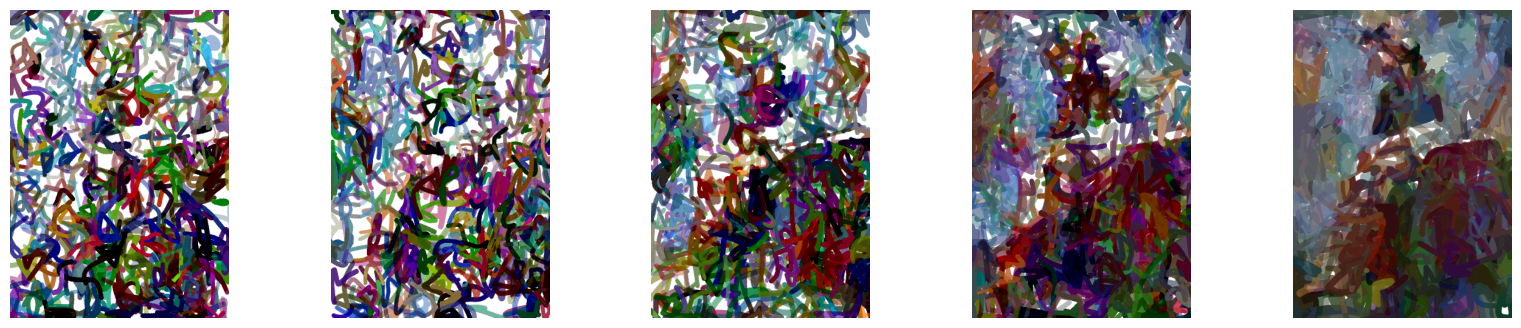

In [23]:
fig, axs = plt.subplots(ncols=imgs.shape[0], figsize=(20, 4))
for img, ax in zip(imgs, axs):
    ax.imshow(img.cpu().detach())
    ax.axis('off')